<a href="https://colab.research.google.com/github/JongHoB/Computer_Vision_PCA/blob/main/%5B2023%5D_CV03_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# - 2023년 컴퓨터비젼 3번째 Assignment
# - 주제: PCA

In [2]:
# connect your google drive here
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



* 준비 작업
1. https://sites.google.com/view/ajoucvpr/home 방문
2. Teaching 메뉴 클릭 -> 2023년 컴퓨터비젼 클릭 -> 3번째 Assignment내 download
3. 본인 구글 drive에 저장

In [3]:
# Common functions
import numpy as np
import cv2
import scipy
import scipy.io
import matplotlib.pyplot as plt
import torch
from torchvision import utils

# convert from image to double
def im2double(im):
  out=torch.div(im, 255.0)
  return out

# convert matlab cell to vector
def cell2vec(inImage):
  nImage=len(inImage)
  sy, sx=inImage.size(2),inImage.size(3)
  image=torch.zeros(sx*sy,nImage)
  for i in range(nImage):
    temp=im2double(inImage[i])
    temp=torch.flatten(temp.T,start_dim=0)
    image[:,i]=temp[:]
  return image, nImage, sy, sx

# show a single image
def showSingleImage(U, name):
  singleImage=torch.unsqueeze(U,dim=0)
  singleImage=singleImage.expand(3,U.size(0))
  plt.title(name)
  plt.imshow(torch.rot90(torch.reshape(singleImage,(3,32,32)),-1,[1,2]).permute(1,2,0))

# show the first k images
def showImage(U,name):
  flag = 0;
  U_t=U[:]
  image_sample2=[]

  m=U.size(U.dim()-1)
  for i in range(100):
    if 32 >= m:
      flag = 1
      image_sample2.append(U_t[i,:])

    else:
      j=U_t[:,i]
      j_min,_=torch.min(j,dim=0)
      j_max,_=torch.max(torch.sub(j,j_min),dim=0)
      j_s=torch.div(j,j_max)
      image_sample2.append( torch.flip(torch.rot90(torch.reshape(j_s,(1,32,32)),-1,[1,2]), (2,)))

  image_sample2=torch.stack(image_sample2)
  plt.figure(figsize=(6,8))
  plt.title(name)
  image_sample=utils.make_grid(image_sample2,nrow=10,normalize=True)
  plt.imshow(image_sample.permute(1,2,0))

In [4]:
# PCA function
def PCA(X):
  Cov = torch.cov(X)
  #L, V = torch.eig(Cov, eigenvectors=True)
  L, V = torch.linalg.eig(Cov)
  # if you get the complex terms from L and V, there is a small sample size problem. You shoud pay more attention to this problem.
  L = L.real # L could be complex terms!
  V = V.real # V could be complex terms!
  return L, V

* 아래 CelebA_mini.mat 위치를 절대 경로로 지정해야함

<ipython-input-5-b530e72510d6>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_image = torch.Tensor(list(train_image))
<ipython-input-3-dca0d2c1bb89>:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  temp=torch.flatten(temp.T,start_dim=0)


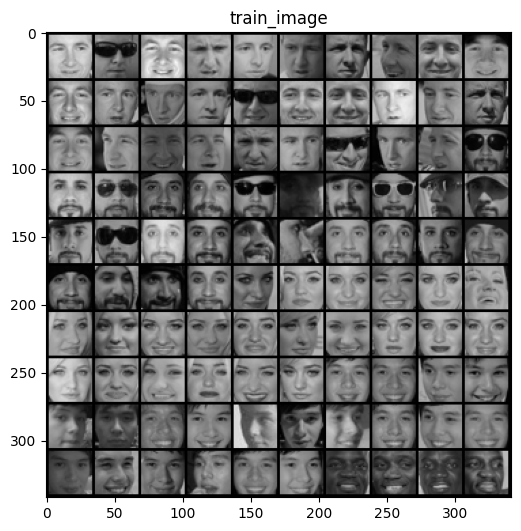

In [5]:
# main script for the PCA

#if __name__ == "__main__":

# prepare the data for PCA
# 아래 path는 본인 directory로 변경해야함!!!!!!!
mat = scipy.io.loadmat('./drive/MyDrive/Colab Notebooks/CelebA_mini.mat')
#                                                       ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#train_label = mat['train_label'] #
train_image = mat['train_image'] #
#train_attr = mat['train_attr']
#test_label = mat['test_label']
test_image = mat['test_image']
#test_attr = mat['test_attr']

#train_label = np.int16(train_label)
#train_label = torch.from_numpy(train_label)
train_image = torch.Tensor(list(train_image))
train_image, _, _, _ = cell2vec(train_image)
#train_attr = torch.from_numpy(np.int16(train_attr))

test_image = torch.Tensor(list(test_image))
test_image, _, _, _ = cell2vec(test_image)
#test_attr = torch.from_numpy(np.int16(test_attr))

showImage(train_image, "train_image")

* PCA 학습 코드

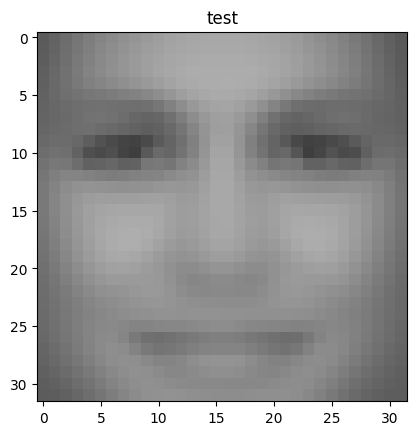

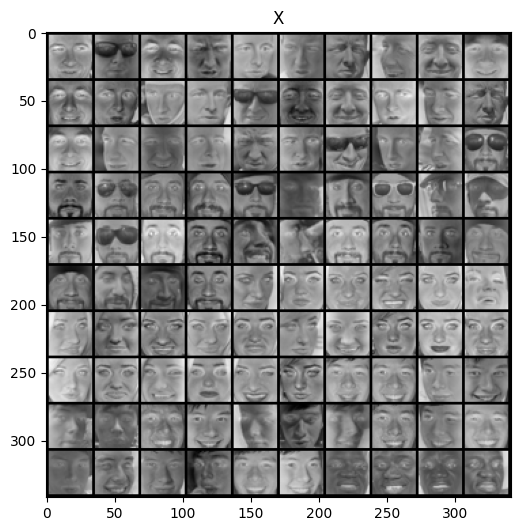

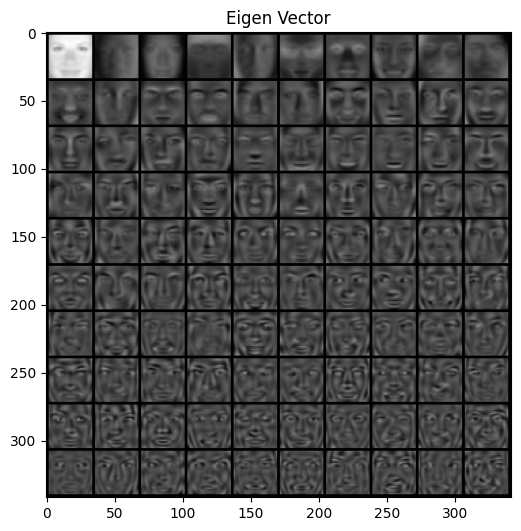

In [6]:
# train PCA script
n,m = train_image.size(0),train_image.size(1)

# train mean
mu = torch.mean(train_image,dim=1)

showSingleImage(mu, "test")

# centerization using mean
X = train_image - mu.repeat(m,1).T

# training PCA
L, V = PCA(X)

showImage(X, "X")
showImage(V, "Eigen Vector")



*   학습데이터에 대한 PCA dimension reduction



[1] Average Pixel Difference (k=100) is 0.0457


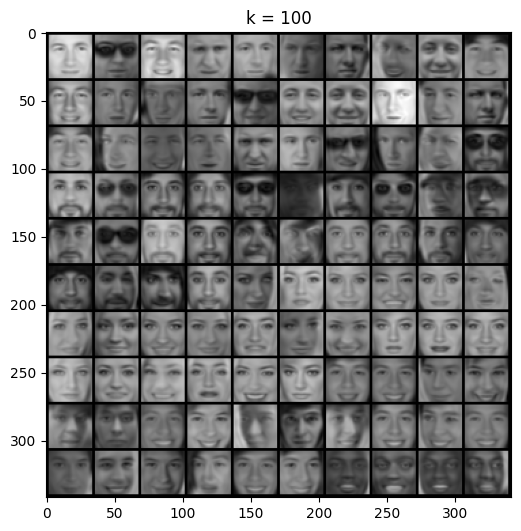

In [7]:
# selecting the first 50 basis eigenvectors
k = 100 # max is 1024

# linear projection using PCA
y = torch.mm(V[:,0:k].T, train_image - mu.repeat(m,1).T)

# reconstructed image
rx = torch.mm(V[:, 0:k],y) + mu.repeat(m,1).T

showImage(rx, "k = 100");

# calculate the difference between the reconstructed images and the input images
diff = torch.pow( rx - train_image, 2)
diff = torch.sqrt( torch.mean(diff[:]) )
print(f'[1] Average Pixel Difference (k={k}) is {diff.numpy():0.4f}')

[1] Average Pixel Difference (k=1024) is 0.0006


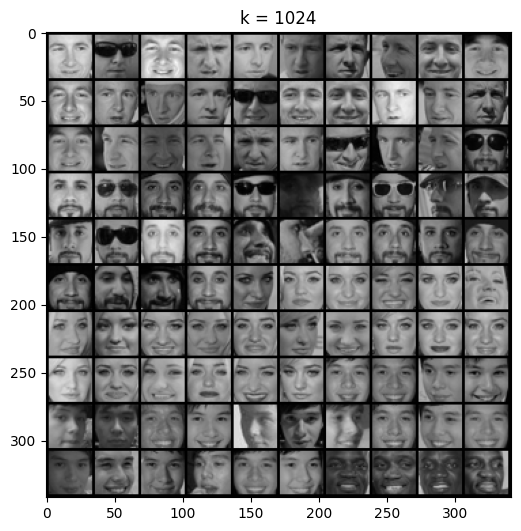

In [8]:
# Selecting the first 1024 basis eigenvectors
k = 1024 # max is 1024

# linear projection using PCA
y = torch.mm(V[:,0:k].T, train_image-mu.repeat(m,1).T)

# reconstructed image
rx = torch.mm(V[:, 0:k],y) + mu.repeat(m,1).T

showImage(rx,"k = 1024");

#calculate the difference between the reconstructed images and the input images
diff = torch.pow(rx - train_image, 2)
diff = torch.sqrt(torch.mean(diff[:]))
print(f'[1] Average Pixel Difference (k={k}) is {diff.numpy():0.4f}')

##  **[문제 1]** test_image를 이용해서 k = 50일때 Average Pixel Difference를 구한다.

[1] Average Pixel Difference (k=50) is 0.0616


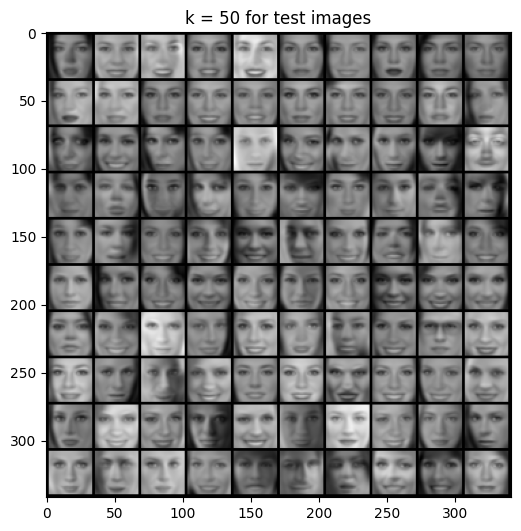

In [9]:
# test images

# Selecting the first 1000 basis eigenvectors
k = 50

n,m = test_image.size(0),test_image.size(1)

# linear projection using PCA
#################################################
# 이곳에 코드 작성 : write your code here
y =torch.mm(V[:,0:k].T, test_image-mu.repeat(m,1).T)

# reconstructed image
#################################################
# 이곳에 코드 작성 : write your code here
rx =torch.mm(V[:,0:k],y)+mu.repeat(m,1).T

showImage(rx,"k = 50 for test images");

#calculate the difference between the reconstructed images and the input images
diff = torch.pow(rx - test_image, 2)
diff = torch.sqrt(torch.mean(diff[:]))
print(f'[1] Average Pixel Difference (k={k}) is {diff.numpy():0.4f}')

##  **[문제 2]** test_image를 이용해서 k=1000일때 Average Pixel Difference를 구한다.

[1] Average Pixel Difference (k=1000) is 0.0022


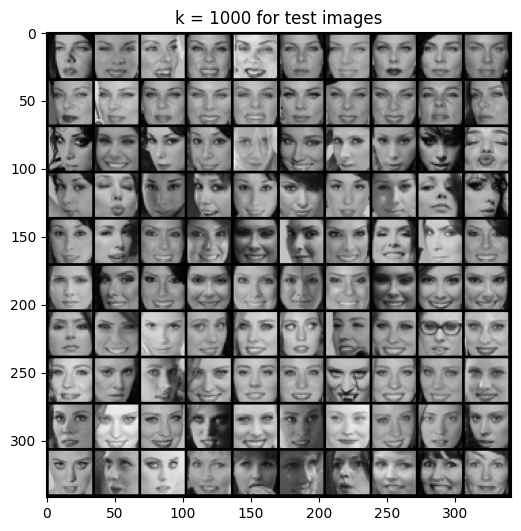

In [10]:
# Selecting the first 1000 basis eigenvectors
k = 1000

# linear projection using PCA
#################################################
# 이곳에 코드 작성 : write your code here
y =torch.mm(V[:,0:k].T, test_image-mu.repeat(m,1).T)

# reconstructed image
#################################################
# 이곳에 코드 작성 : write your code here
rx =torch.mm(V[:,0:k],y)+mu.repeat(m,1).T

showImage(rx,"k = 1000 for test images");

#calculate the difference between the reconstructed images and the input images
diff = torch.pow(rx - test_image, 2)
diff = torch.sqrt(torch.mean(diff[:]))
print(f'[1] Average Pixel Difference (k={k}) is {diff.numpy():0.4f}')

## **[문제 3]** 입력 영상이 random일때 k 값의 변화에 따라서 어떤 영상이 나타나는지 확인 할 것

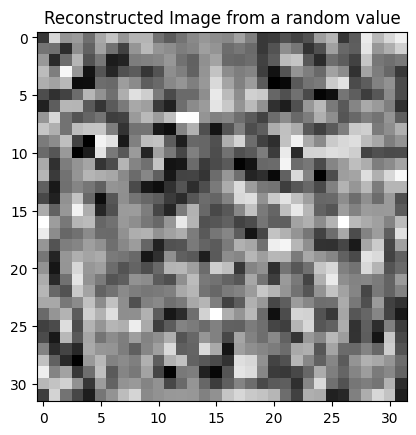

In [22]:
x = torch.rand(1024,1)

n,m = x.size(0),x.size(1)
#################################################
# 이곳에 코드 작성 : write your code here
k =500

# linear projection using PCA
#################################################
# 이곳에 코드 작성 : write your code here
y =torch.mm(V[:,0:k].T, x-mu.repeat(m,1).T)

# reconstructed image
#################################################
# 이곳에 코드 작성 : write your code here
rx =torch.mm(V[:,0:k],y)+mu.repeat(m,1).T

showSingleImage(torch.reshape(rx, (-1,)), "Reconstructed Image from a random value")